# 1. Project overview
We will try to predict the breed of dogs through the images.
In the cnn/dog_breeder_model.py file you can find the implementation of the class that is used to analyse, create and use the model.
We're using the CNN to classify the images of dogs. We're also taking advantage of transfer learning, in this case byt taking a pre-trained CNN model used in a similiar scenario (ResNet50). This helps us get better accuracy and less training time to get better accuracy.

# 2. Variables initialization


In [1]:
from cnn.dog_breeder_model import DogBreeder
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
%matplotlib inline

dog_breeder = DogBreeder()

2022-12-14 16:41:29.402833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Since we will use transfer learning from the ResNet50 model, as a first step we will extract all the features.
If resnet.npy file is present, it will load from it. Else it will extract the features from the images.
You can download here [resnet.zip](https://dogbreedfinder.app/resnet.zip)
While if you want to extract the features from the images, you can download them here [dogs_images](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip)

In [2]:
dog_breeder.load_or_create_datasets()

# 3. Data visualization
We divide our data in 3 datasets: train, validation and test. We use train data to train the model, validation data for the accuracy metric of the model to avoid overfitting, and test data to get the final accuracy numbers.

In [17]:
print('train data size: {}'.format(len(dog_breeder.train_targets)))
print('validation data size: {}'.format(len(dog_breeder.valid_targets)))
print('test data size: {}'.format(len(dog_breeder.test_targets)))

train data size: 6679
validation data size: 835
test data size: 836


### All dataset

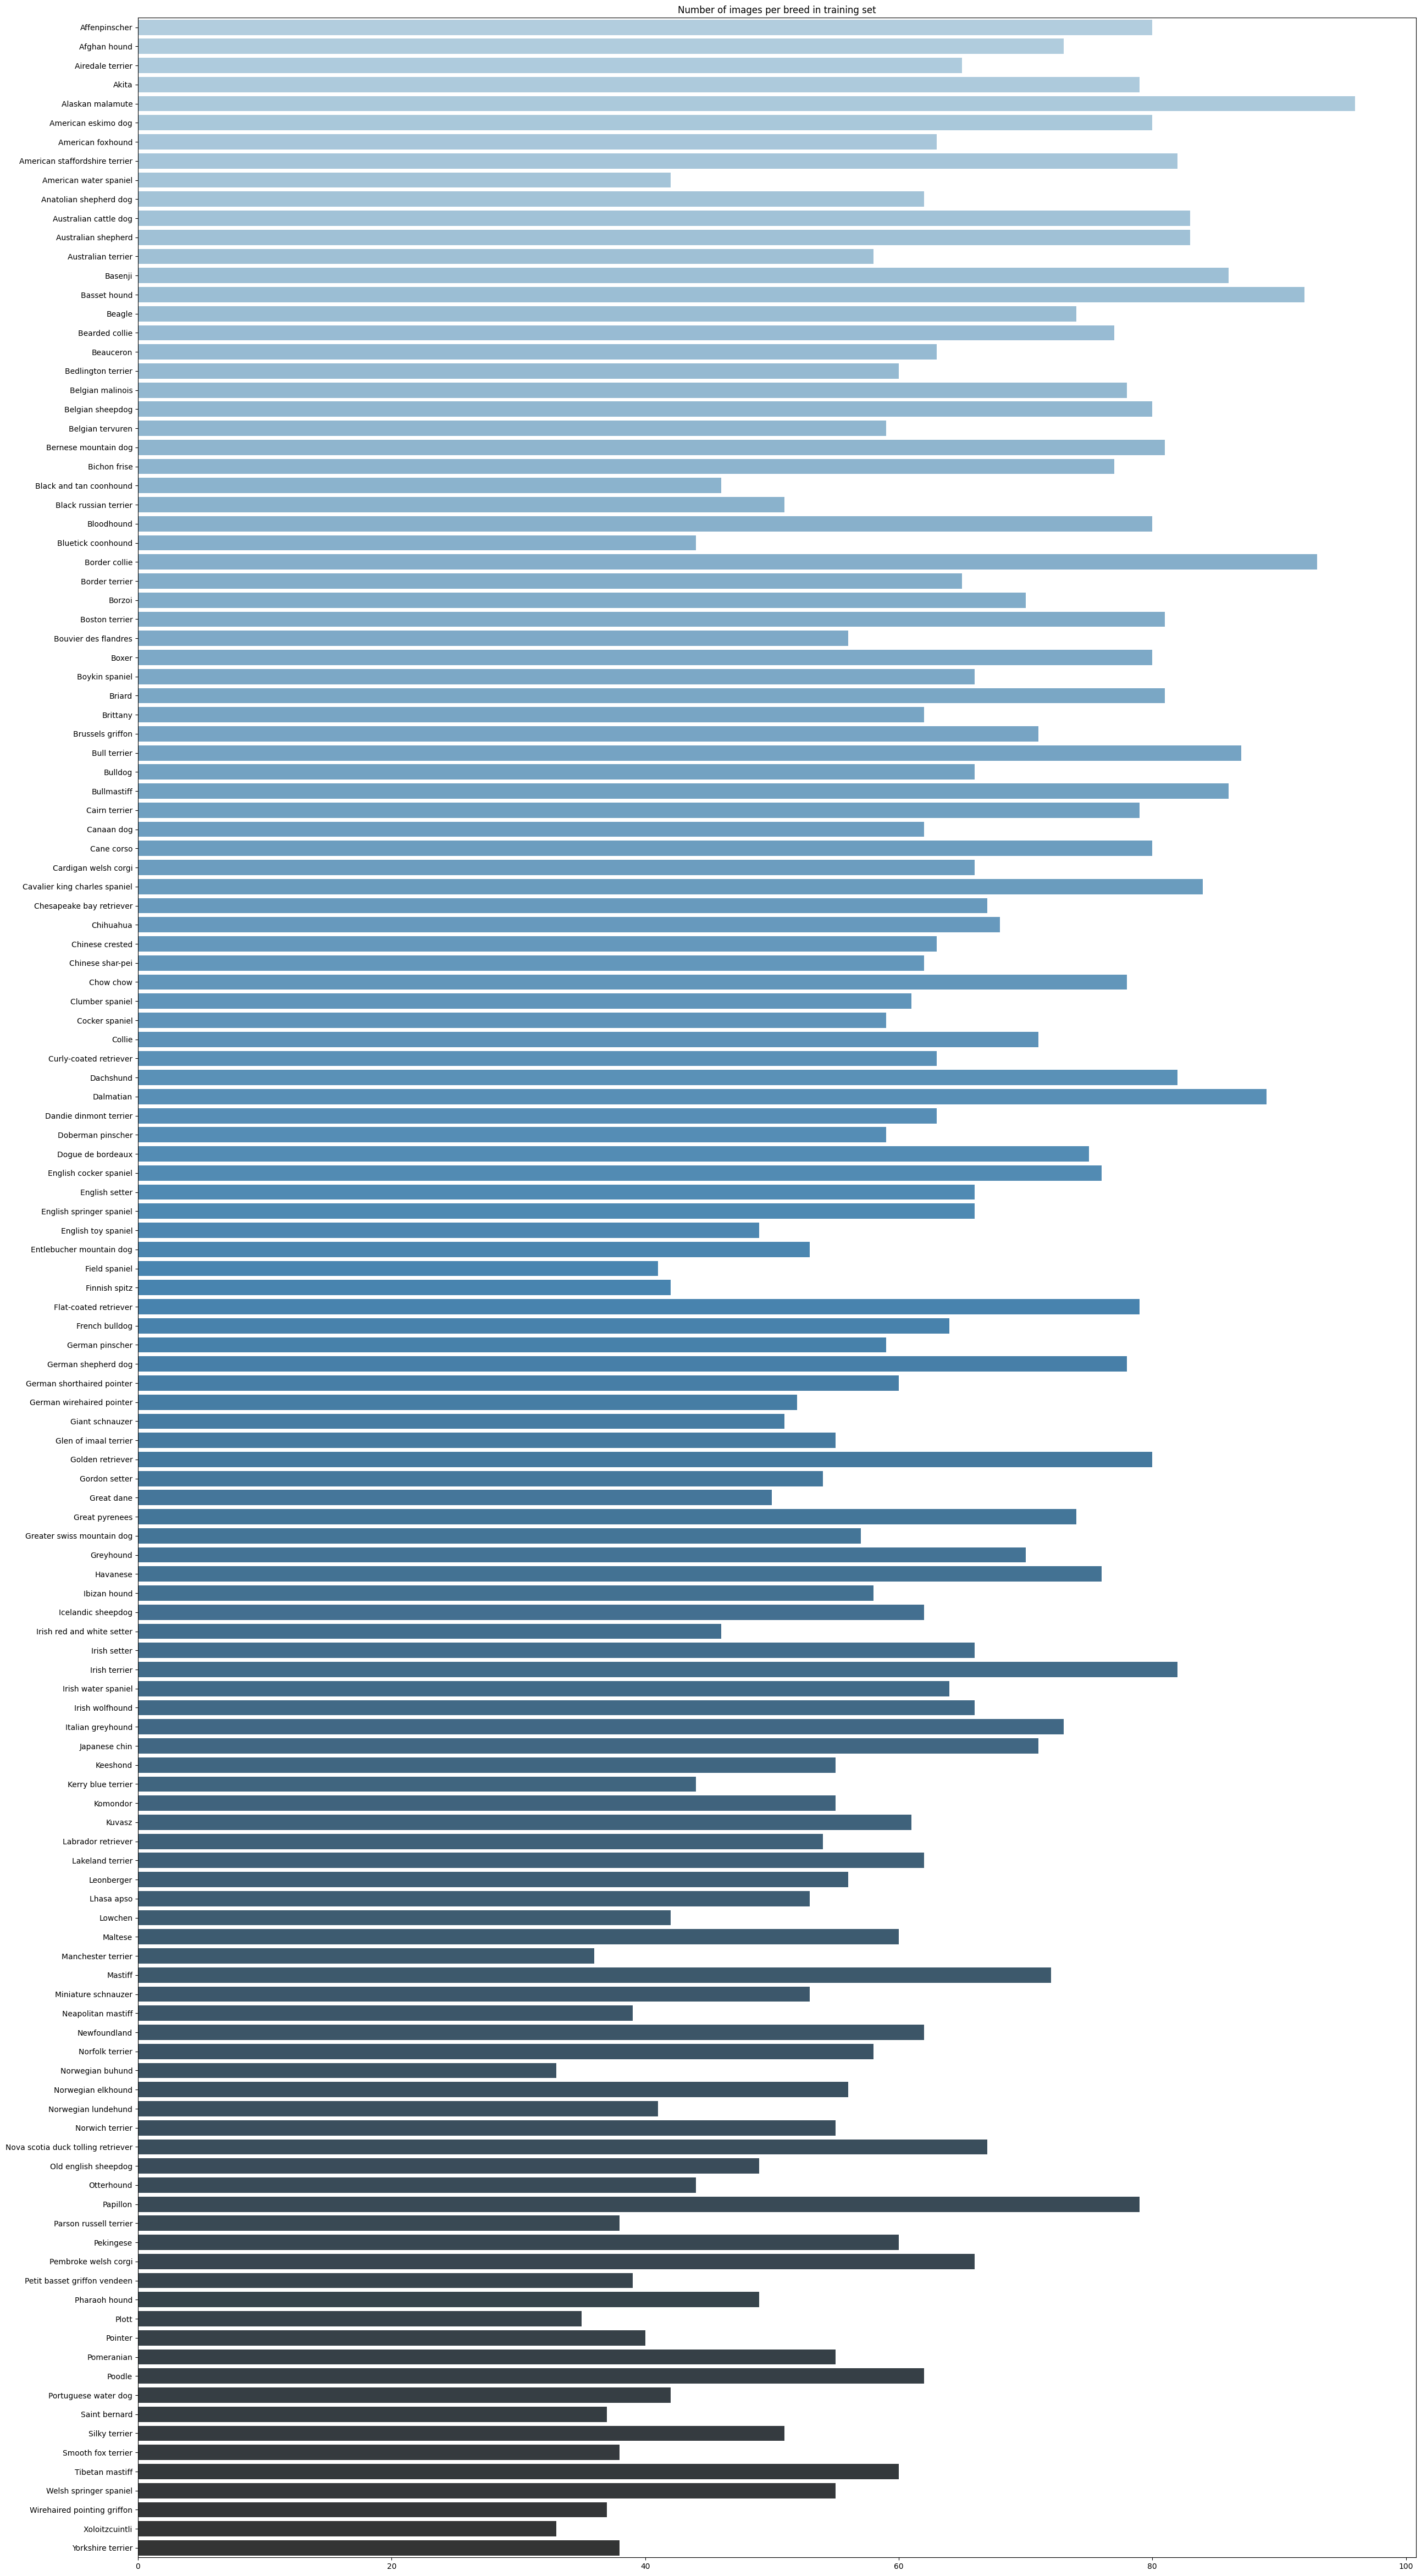

In [3]:
dog_breeder.print_dataset_info(np.concatenate((dog_breeder.train_targets, dog_breeder.valid_targets, dog_breeder.test_targets)))

### Train dataset

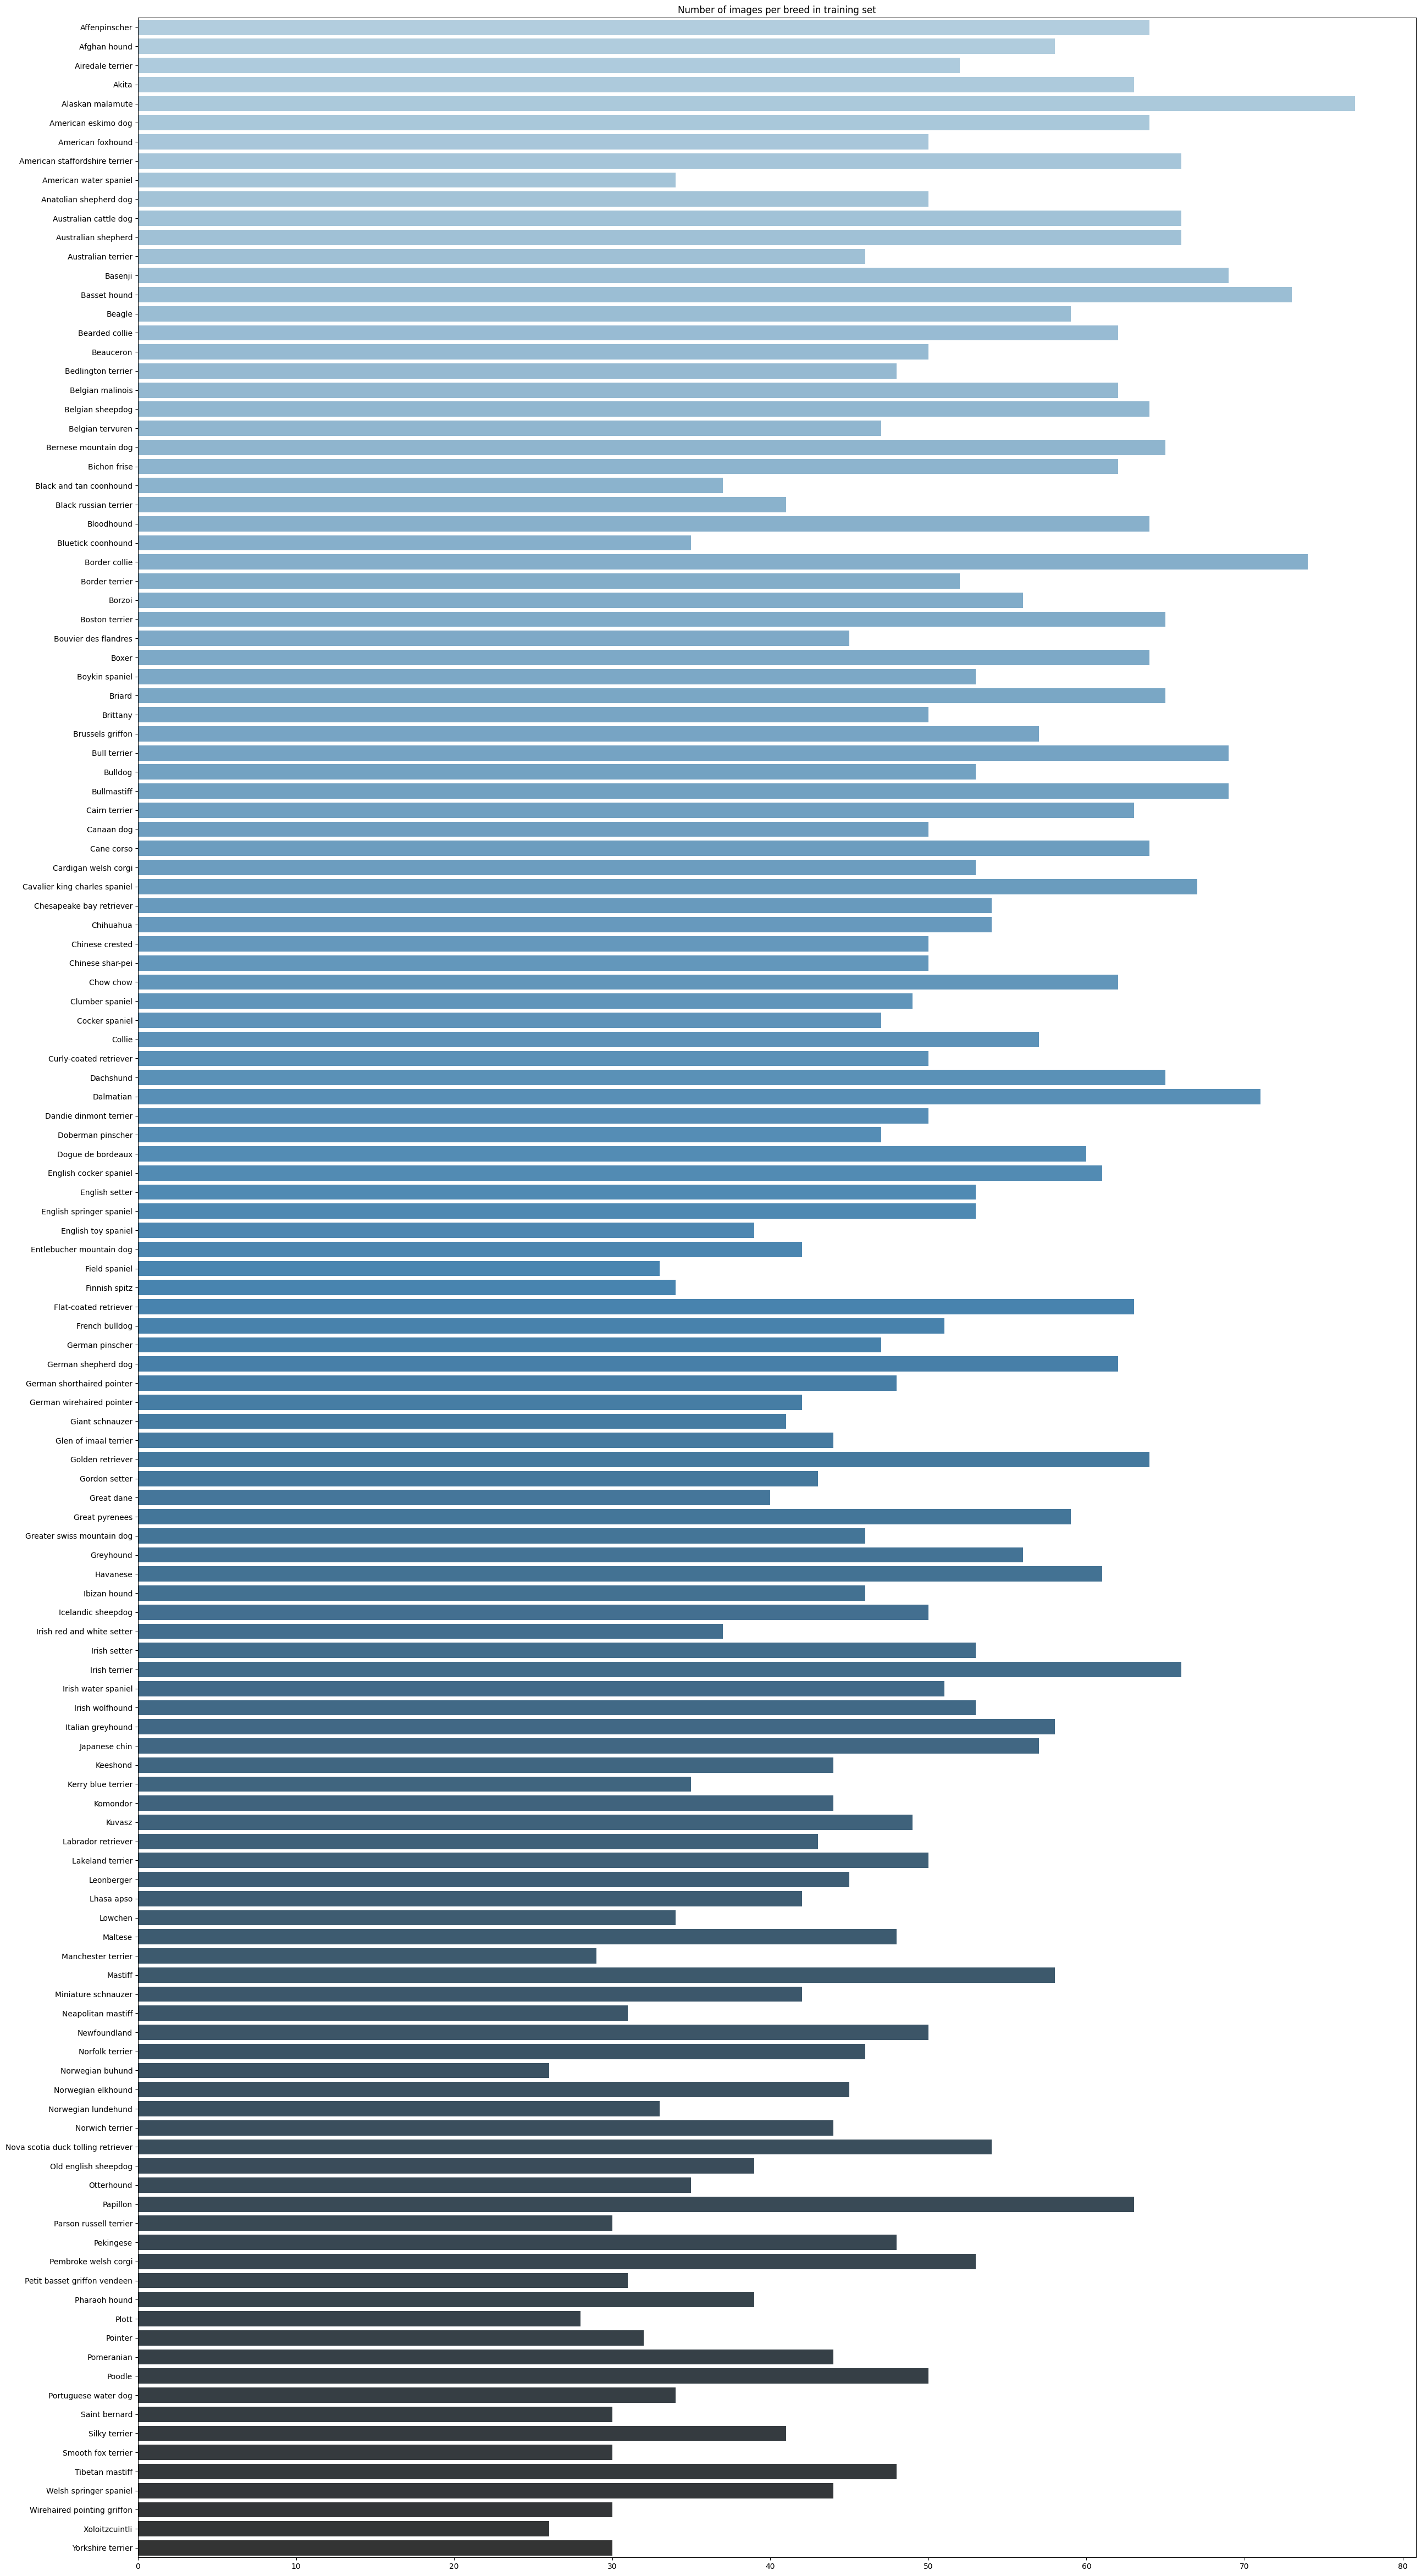

In [4]:
dog_breeder.print_dataset_info(dog_breeder.train_targets)

### Validation dataset

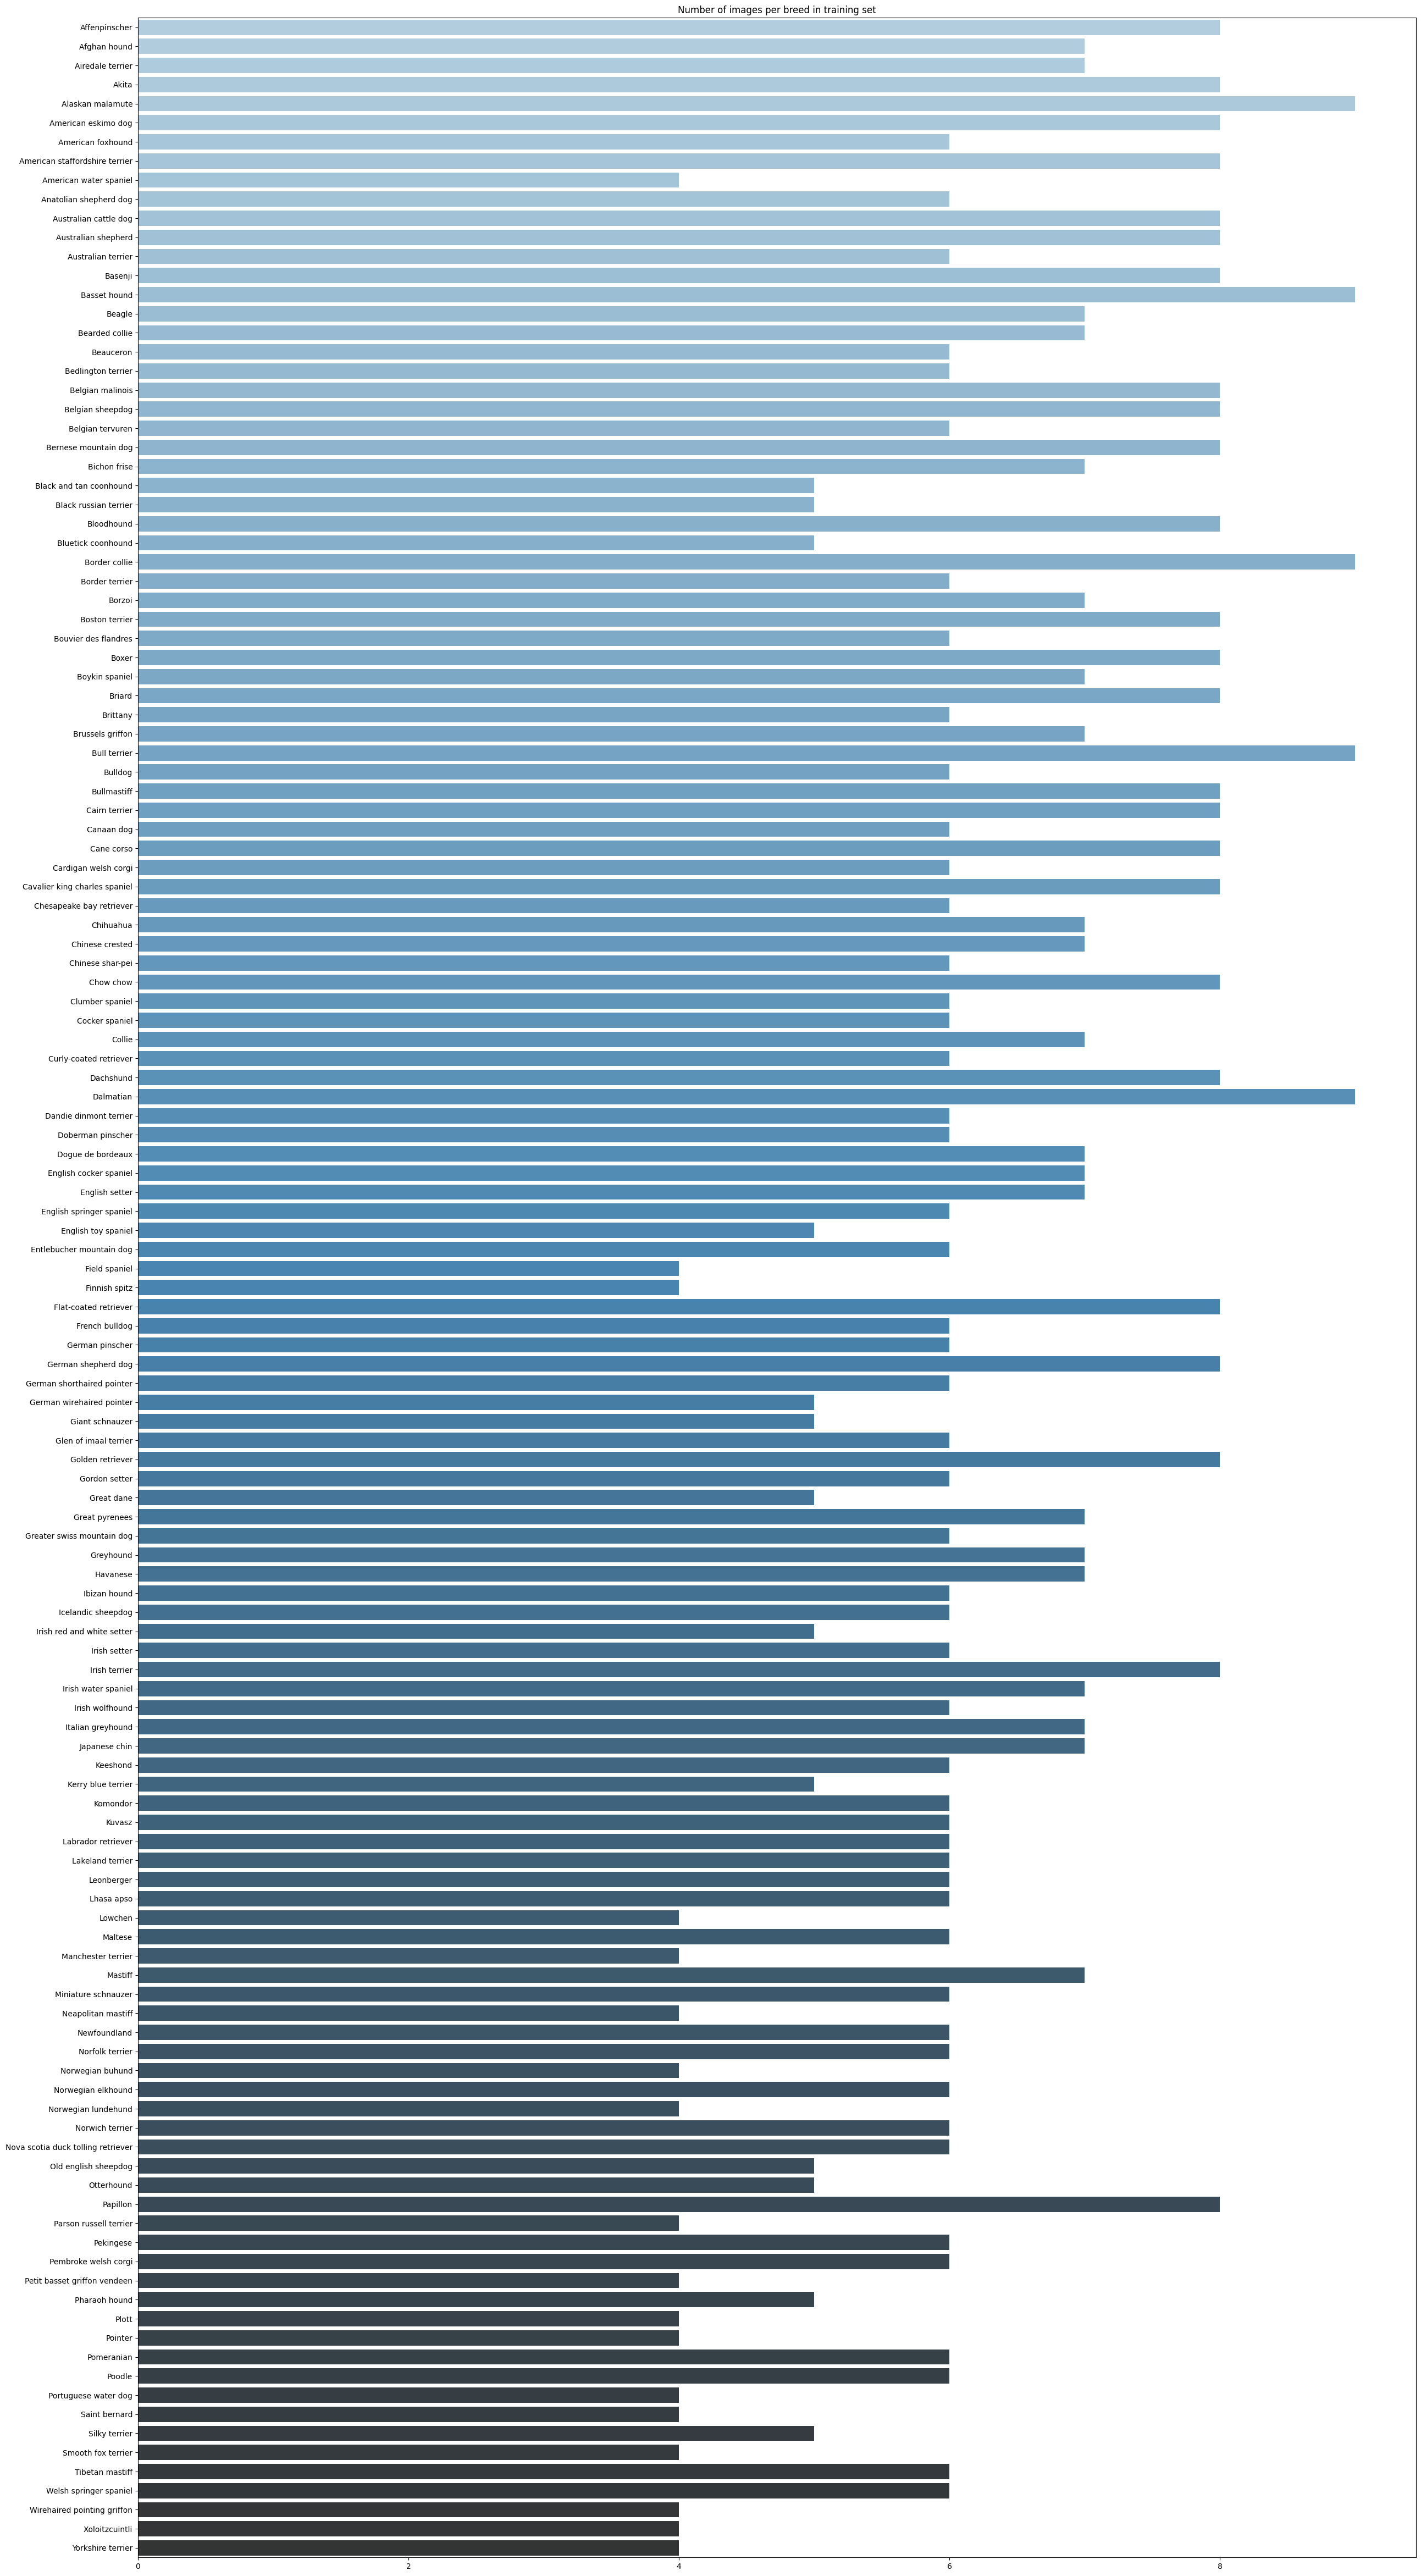

In [5]:
dog_breeder.print_dataset_info(dog_breeder.valid_targets)

### Test dataset

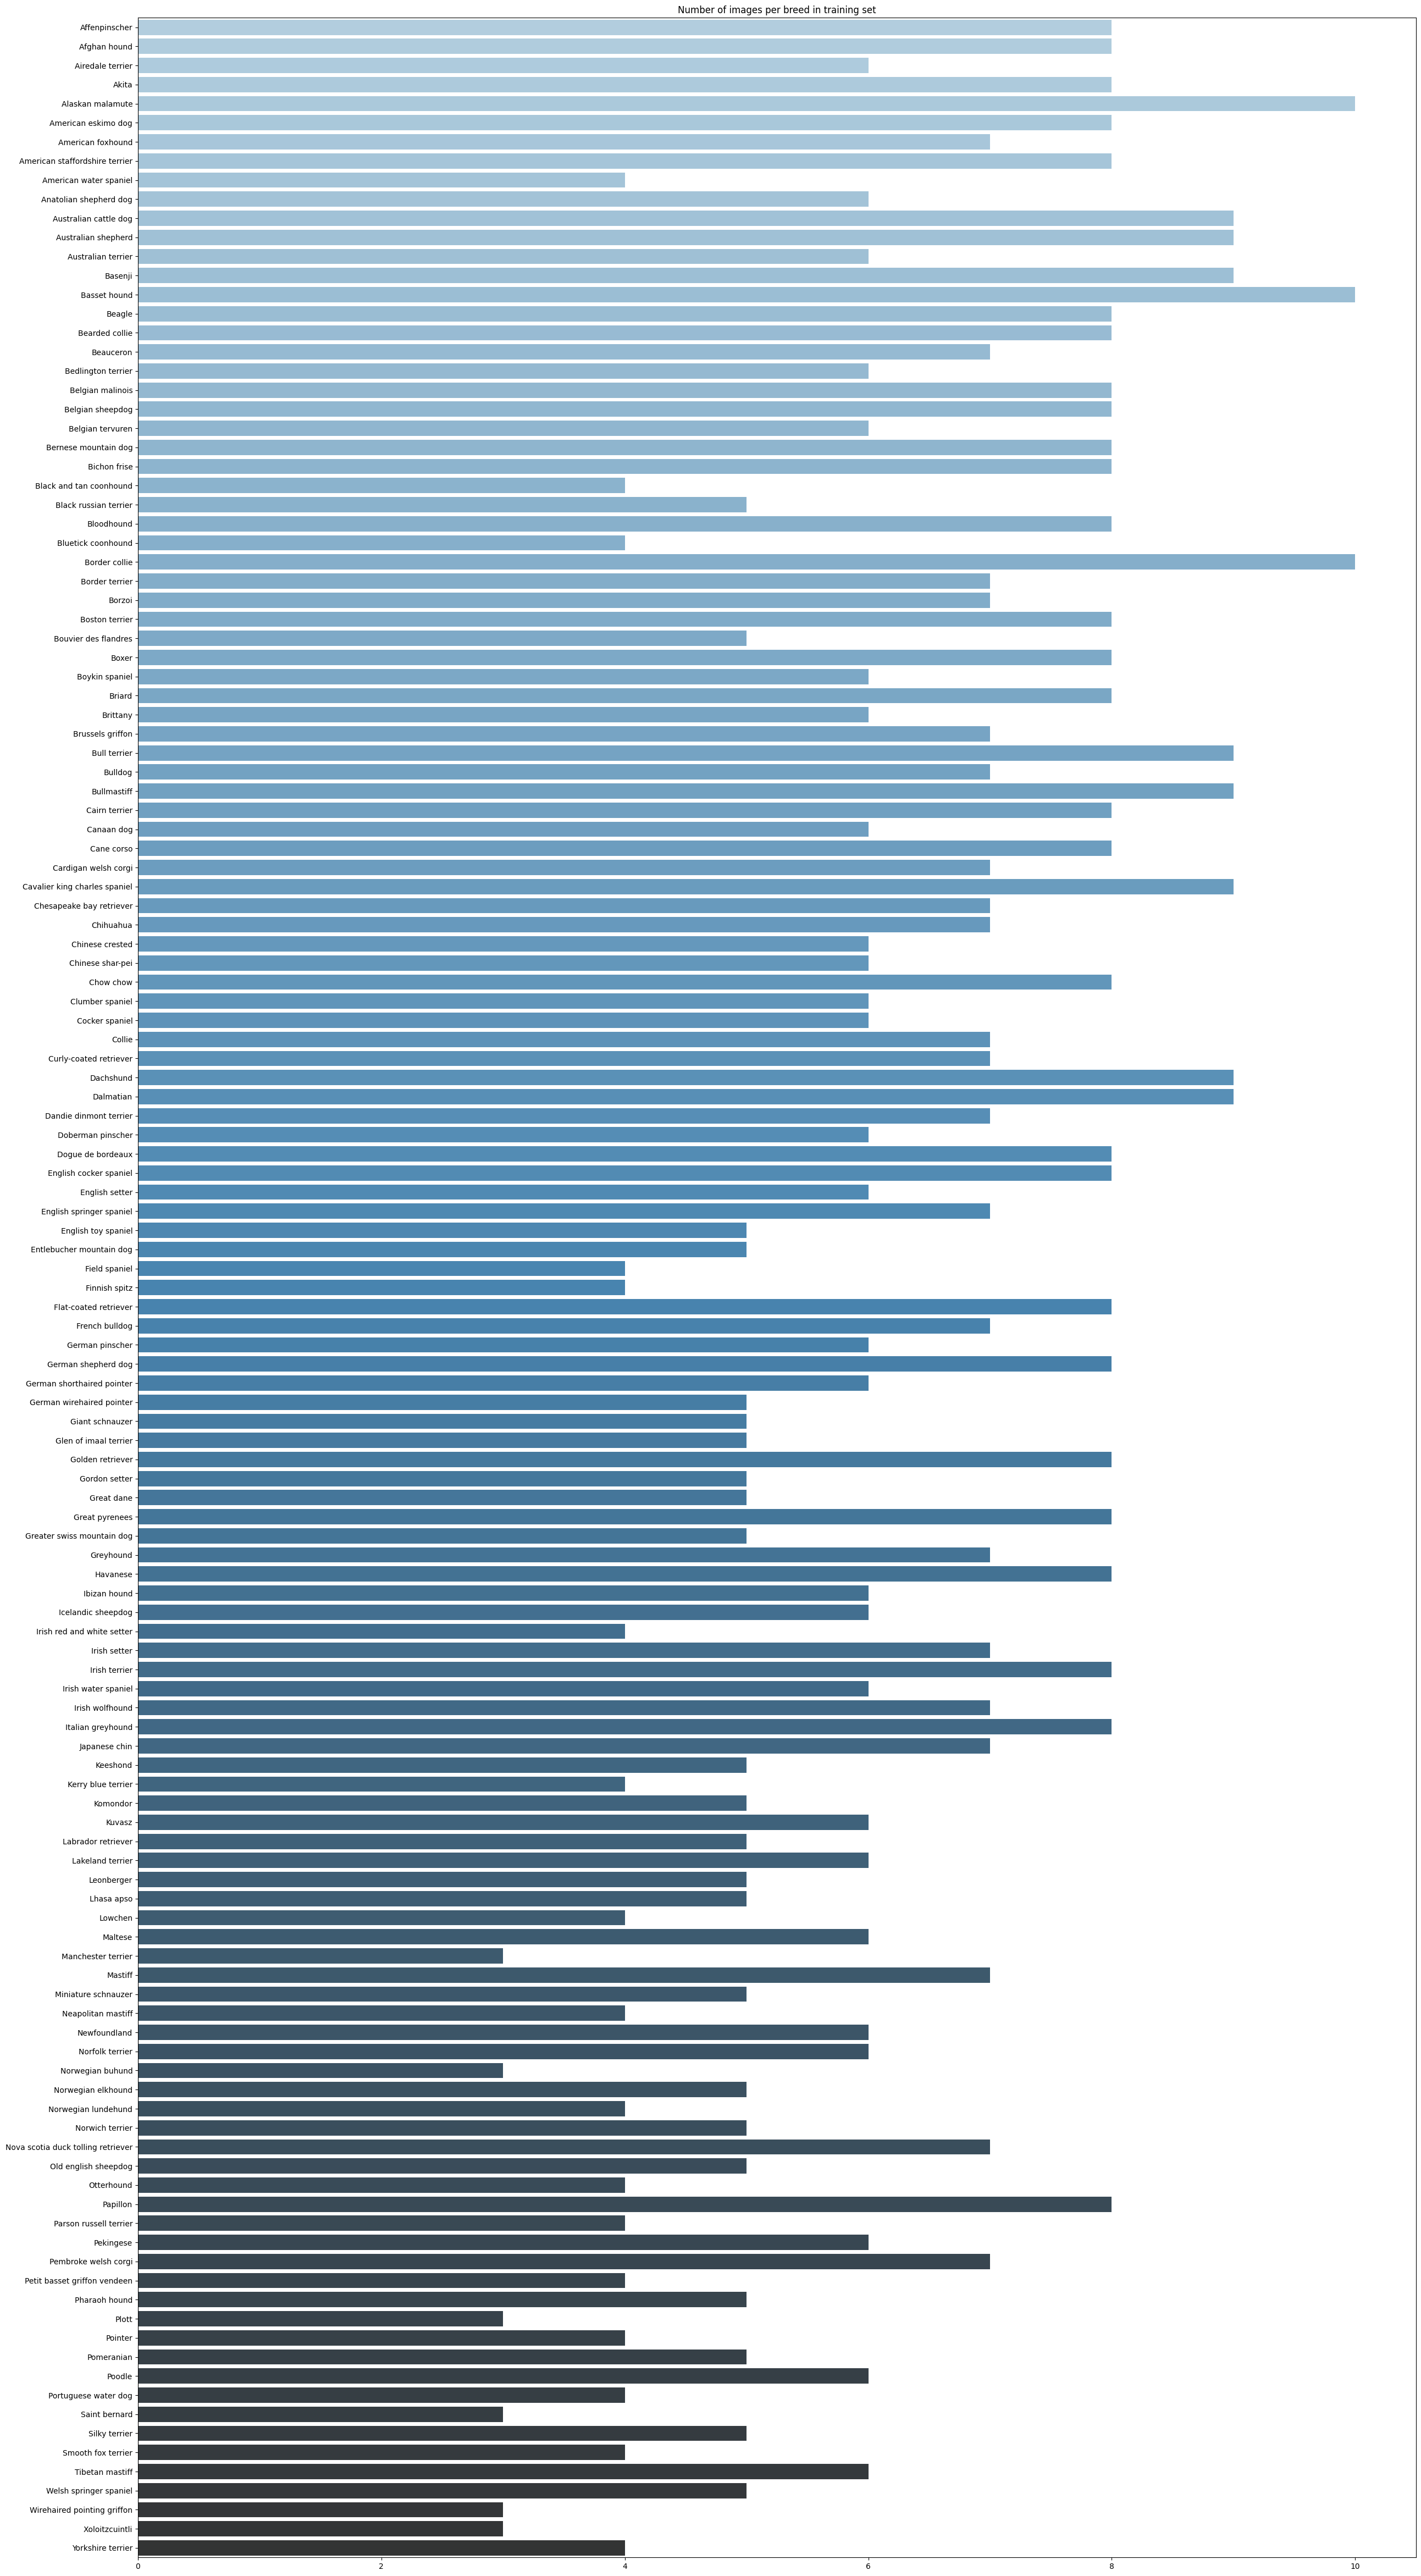

In [6]:
dog_breeder.print_dataset_info(dog_breeder.test_targets)

The data is not perfectly balanced, but for our purpose we will still use the accuracy as a metric for the model training because we have many output classes.

In [7]:
dog_breeder.init_custom_model()
dog_breeder.dog_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 532)               1090068   
                                                                 
 dropout (Dropout)           (None, 532)               0         
                                                                 
 dense_1 (Dense)             (None, 266)               141778    
                                                                 
 dropout_1 (Dropout)         (None, 266)               0         
                                                                 
 dense_2 (Dense)             (None, 133)               35511     
                                                        

2022-12-14 16:41:52.325721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
dog_breeder.dog_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Now we will create an augmented image generator by shifting and flipping the images.

In [12]:
datagen_resnet_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

datagen_resnet_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

datagen_resnet_train.fit(dog_breeder.train_resnet)
datagen_resnet_valid.fit(dog_breeder.valid_resnet)

/Users/artem/.local/share/virtualenvs/DogBreed-CNN-8203z7xm/lib/python3.9/site-packages/keras/preprocessing/image.py:2092: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (6679, 7, 7, 2048) (2048 channels).
  warnings.warn(
/Users/artem/.local/share/virtualenvs/DogBreed-CNN-8203z7xm/lib/python3.9/site-packages/keras/preprocessing/image.py:2092: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (835, 7, 7, 2048) (2048 channels).
  warnings.warn(


We train the model with the generator created above. For this example we will run only for 10 epochs and use . In the real model we will run for 200 epochs.

In [13]:
checkpointer = ModelCheckpoint(filepath='model_notebook.hdf5', verbose=1, save_best_only=True, save_weights_only=False)
epochs = 10
batch_size = 20
dog_breeder.dog_model.fit_generator(datagen_resnet_train.flow(dog_breeder.train_resnet, dog_breeder.train_targets, batch_size=batch_size),
                    steps_per_epoch=dog_breeder.train_resnet.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_resnet_valid.flow(dog_breeder.valid_resnet, dog_breeder.valid_targets, batch_size=batch_size),
                    validation_steps=dog_breeder.valid_resnet.shape[0] // batch_size)
dog_breeder.dog_model.load_weights('model_notebook.hdf5') 

/Users/artem/.local/share/virtualenvs/DogBreed-CNN-8203z7xm/lib/python3.9/site-packages/keras/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (6679, 7, 7, 2048) (2048 channels).
  warnings.warn(
/Users/artem/.local/share/virtualenvs/DogBreed-CNN-8203z7xm/lib/python3.9/site-packages/keras/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (835, 7, 7, 2048) (2048 channels).
  warnings.warn(
/var/folders/tb/_c4k48m10913x6yv5_y7qgkw0000gn/T/ipykernel_59160/2971050229.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  dog_breeder.do

Epoch 1/10
333/333 [==============================] - ETA: 0s - loss: 2.5451 - accuracy: 0.3906
Epoch 1: val_loss improved from inf to 1.01480, saving model to model_notebook.hdf5
333/333 [==============================] - 1781s 5s/step - loss: 2.5451 - accuracy: 0.3906 - val_loss: 1.0148 - val_accuracy: 0.6732
Epoch 2/10
333/333 [==============================] - ETA: 0s - loss: 1.0721 - accuracy: 0.6756
Epoch 2: val_loss improved from 1.01480 to 0.85998, saving model to model_notebook.hdf5
333/333 [==============================] - 378s 1s/step - loss: 1.0721 - accuracy: 0.6756 - val_loss: 0.8600 - val_accuracy: 0.7293
Epoch 3/10
333/333 [==============================] - ETA: 0s - loss: 0.8052 - accuracy: 0.7515
Epoch 3: val_loss improved from 0.85998 to 0.75256, saving model to model_notebook.hdf5
333/333 [==============================] - 431s 1s/step - loss: 0.8052 - accuracy: 0.7515 - val_loss: 0.7526 - val_accuracy: 0.7756
Epoch 4/10
333/333 [==============================] - E

Let's test the accuracy of our model.

In [14]:
resnet_predictions = [np.argmax(dog_breeder.dog_model.predict(np.expand_dims(feature, axis=0))) for feature in dog_breeder.test_resnet]
test_accuracy = 100*np.sum(np.array(resnet_predictions)==np.argmax(dog_breeder.test_targets, axis=1))/len(resnet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 67ms/step
Test accuracy: 78.8278%


Now let's test the accuracy of the model with 200 epochs.

In [15]:
dog_breeder.load_model_from_file()
resnet_predictions = [np.argmax(dog_breeder.dog_model.predict(np.expand_dims(feature, axis=0))) for feature in dog_breeder.test_resnet]
test_accuracy = 100*np.sum(np.array(resnet_predictions)==np.argmax(dog_breeder.test_targets, axis=1))/len(resnet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 21ms/step
Test accuracy: 80.5024%


# Conclusion

We got a good accuracy score of 80.5%, but it could be further improved using a different pre-trained model (like VGG-19, Inception or Exception).

We could probably see better results by adding more layers, traing the model with more images and/or use a grid search for parameters tuning, but that would require more resources.